# Fine Tuning Roberta for Sentiment Analysis





In [ ]:
!pip install transformers
!pip install comet_ml

In [2]:
def set_experiment(api_key, project_name, workspace):
    experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace
)
    
    return experiment

In [ ]:
import comet_ml
from comet_ml import Experiment

api_key = xxx
project_name = xxx
workspace = xxx

experiment = set_experiment(api_key, project_name, workspace)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

import tqdm
import torch
import transformers
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

In [5]:
import regex as re

In [6]:
def log_parameters(experiment, hyper_params):
    experiment.log_parameter("train_batch_size", hyper_params['batch_size'])
    experiment.log_parameter("test_batch_size", hyper_params['batch_size'])

    experiment.log_parameter("Learning Rate", hyper_params['lr'])
    experiment.log_parameter("general_epochs", hyper_params['epochs'])
    experiment.log_parameter("lr_decay", hyper_params['lr_decay'])
    experiment.log_parameter("max_len", hyper_params['max_len'])

In [7]:
X_train = pd.read_csv('train2.csv', header=0)
X_dev = pd.read_csv('dev2.csv', header=0)
X_test = pd.read_csv('test2.csv', header=0)

In [8]:
X_train['Text'] = X_train["Text"].str.lower()
X_dev['Text'] = X_dev["Text"].str.lower()
X_test['Text'] =X_test["Text"].str.lower()

In [9]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    per_pattern = re.compile(r'@[^\s]+')
    return per_pattern.sub(r'', url_pattern.sub(r'', text))

X_train['Text'] = [remove_urls(i) for i in X_train['Text']]
X_dev['Text'] = [remove_urls(i) for i in X_dev['Text']]
X_test['Text'] = [remove_urls(i) for i in X_test['Text']]

In [10]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

X_train['Text'] = [remove_emojis(i) for i in X_train['Text']]
X_dev['Text'] = [remove_emojis(i) for i in X_dev['Text']]
X_test['Text'] = [remove_emojis(i) for i in X_test['Text']]

In [11]:
stop = 'и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, почти, мой, тем, чтобы, нее, сейчас, были, куда, зачем, всех, при, наконец, два, об, другой, хоть, после, над, больше, тот, через, эти, нас, про, всего, них, какая, много, разве, три, эту, моя, свою, этой, перед, чуть, том, нельзя, такой, им, всегда, всю, между'
stop = set(stop.replace(',', '').split())

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stop])

X_train['Text'] = [remove_stopwords(i) for i in X_train['Text']]
X_dev['Text'] = [remove_stopwords(i) for i in X_dev['Text']]
X_test['Text'] = [remove_stopwords(i) for i in X_test['Text']]

<a id='section03'></a>
### Preparing the Dataset and Dataloader

In [ ]:
parameters = { 'max_len'    : 256,
               'batch_size' : 32,
               'epochs'     : 10,
               'lr'         : 2e-5,
               'lr_decay'   : 0.2
             }

from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

model = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")

#tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment', truncation=True, do_lower_case=True)
device = 'cuda' if cuda.is_available() else 'cpu'

In [13]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = dataframe.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
train_set = CustomDataset(X_train, tokenizer, parameters['max_len'])
val_set = CustomDataset(X_dev, tokenizer, parameters['max_len'])
test_set = CustomDataset(X_test, tokenizer, parameters['max_len'])

In [15]:
train_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': parameters['batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning


In [16]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")
        self.pre_classifier = torch.nn.Linear(83828, 256)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(256, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooler = output_1[0][:, 0, :]
        #pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [17]:
log_parameters(experiment, parameters)

In [18]:
model = RobertaClass()
model.to(device)

experiment.set_model_graph(model, True)

<a id='section05'></a>
### Fine Tuning the Model

In [19]:
from torch.optim.lr_scheduler import StepLR

In [20]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=parameters['lr'], eps=1e-8)
lr_scheduler = StepLR(optimizer, step_size=4, 
                      gamma=parameters['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 2.0000e-05.


In [21]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [22]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, experiment, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------" * 4}')
        
        tr_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0
        tr_accuracy = 0.0
        
        model.train()
        
        for step, data in enumerate(train_dl):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            optimizer.zero_grad()
            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            
            tr_loss += loss.item() 
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            
            loss.backward()
            optimizer.step()

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if (step % 100 == 0 and step != 0) or (step == len(train_dl) - 1):
                # Calculate time elapsed for 20 batches
                print(f"{epoch + 1:^7} | {step:^7} |")

            
        train_loss = tr_loss/nb_tr_steps
        train_losses.append(train_loss)
        lr_scheduler.step() 
        tr_accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_train', train_loss)

        model.eval() 
        
        vl_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for data in val_dl:
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)

                outputs = model(ids, mask, token_type_ids).squeeze()
                loss = criterion(outputs, targets)

                vl_loss += loss.item() 
                big_val, big_idx = torch.max(outputs.data, dim=1)
                n_correct += calcuate_accuracy(big_idx, targets)

                all_preds += big_idx.tolist()
                all_labels += targets.tolist()

                nb_tr_steps += 1
                nb_tr_examples += targets.size(0)
                
        
        val_loss = vl_loss/nb_tr_steps
        accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_val', val_loss)

        b_accuracy = balanced_accuracy_score(all_labels, all_preds)
        print('Balanced_accuracy know: ', b_accuracy)
        experiment.log_metric('loss_b_accuracy', b_accuracy)

        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t  Train Accuracy: {tr_accuracy:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if b_accuracy > best_accuracy:
            best_accuracy = b_accuracy
            best_model_params = deepcopy(model.state_dict())
            
            output_model_file = f'second_robert_sentiment_{round(b_accuracy, 5)}.bin'

            model_to_save = model
            torch.save(model_to_save, output_model_file)
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [24]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                                                 model, 
                                                                 loss_function, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 val_loader, 
                                                                 parameters['epochs'], 
                                                                 experiment,
                                                                 lr_scheduler)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   1    |   100   |
   1    |   200   |
   1    |   300   |
   1    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7628579645835902
Train Loss: 0.9117 	 Val Loss: 0.6030 	  Train Accuracy: 64.8430 	 Val Accuracy: 76.2871

Epoch 2/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   2    |   100   |
   2    |   200   |
   2    |   300   |
   2    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7686890267563262
Train Loss: 0.5813 	 Val Loss: 0.5914 	  Train Accuracy: 76.9261 	 Val Accuracy: 76.8721

Epoch 3/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   3    |   100   |
   3    |   200   |
   3    |   300   |
   3    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7807679490164391
Train Loss: 0.5198 	 Val Loss: 0.6005 	  Train Accuracy: 79.9200 	 Val Accuracy: 78.0811

Epoch 4/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   4    |   100   |
   4    |   200   |
   4    |   300   |
   4    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7885999150882671
Train Loss: 0.4633 	 Val Loss: 0.6027 	  Train Accuracy: 81.7925 	 Val Accuracy: 78.8612

Epoch 5/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   5    |   100   |
   5    |   200   |
   5    |   300   |
   5    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7850797302911193
Train Loss: 0.3946 	 Val Loss: 0.5976 	  Train Accuracy: 84.8644 	 Val Accuracy: 78.5101

Epoch 6/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   6    |   100   |
   6    |   200   |
   6    |   300   |
   6    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3752 	 Val Loss: 0.5863 	  Train Accuracy: 85.3521 	 Val Accuracy: 79.4072

Epoch 7/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   7    |   100   |
   7    |   200   |
   7    |   300   |
   7    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7882041168495008
Train Loss: 0.3620 	 Val Loss: 0.5908 	  Train Accuracy: 85.9079 	 Val Accuracy: 78.8222

Epoch 8/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   8    |   100   |
   8    |   200   |
   8    |   300   |
   8    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.794040200683859
Train Loss: 0.3497 	 Val Loss: 0.6271 	  Train Accuracy: 86.0250 	 Val Accuracy: 79.4072

Epoch 9/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   9    |   100   |
   9    |   200   |
   9    |   300   |
   9    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7928742621581275
Train Loss: 0.3292 	 Val Loss: 0.6361 	  Train Accuracy: 87.1660 	 Val Accuracy: 79.2902

Epoch 10/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  10    |   100   |
  10    |   200   |
  10    |   300   |
  10    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7936622065181168
Train Loss: 0.3234 	 Val Loss: 0.6417 	  Train Accuracy: 87.5561 	 Val Accuracy: 79.3682

Finished Training and the best accuracy is: 0.7940


In [28]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                                                 model, 
                                                                 loss_function, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 val_loader, 
                                                                 parameters['epochs'], 
                                                                 experiment,
                                                                 lr_scheduler)

Epoch 1/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   1    |   100   |
   1    |   200   |
   1    |   300   |
   1    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3549 	 Val Loss: 0.6099 	  Train Accuracy: 86.2980 	 Val Accuracy: 79.4072

Epoch 2/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   2    |   100   |
   2    |   200   |
   2    |   300   |
   2    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3585 	 Val Loss: 0.5874 	  Train Accuracy: 86.3663 	 Val Accuracy: 79.4072

Epoch 3/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   3    |   100   |
   3    |   200   |
   3    |   300   |
   3    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3490 	 Val Loss: 0.5874 	  Train Accuracy: 86.6686 	 Val Accuracy: 79.4072

Epoch 4/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   4    |   100   |
   4    |   200   |
   4    |   300   |
   4    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3587 	 Val Loss: 0.5857 	  Train Accuracy: 85.9177 	 Val Accuracy: 79.4072

Epoch 5/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   5    |   100   |
   5    |   200   |
   5    |   300   |
   5    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3574 	 Val Loss: 0.5875 	  Train Accuracy: 86.1420 	 Val Accuracy: 79.4072

Epoch 6/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   6    |   100   |
   6    |   200   |
   6    |   300   |
   6    |   320   |
Adjusting learning rate of group 0 to 3.2000e-08.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3584 	 Val Loss: 0.5927 	  Train Accuracy: 86.2103 	 Val Accuracy: 79.4072

Epoch 7/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   7    |   100   |
   7    |   200   |
   7    |   300   |
   7    |   320   |
Adjusting learning rate of group 0 to 3.2000e-08.
Balanced_accuracy know:  0.7940488744630246
Train Loss: 0.3597 	 Val Loss: 0.5863 	  Train Accuracy: 86.2688 	 Val Accuracy: 79.4072

Epoch 8/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   8    |   100   |


KeyboardInterrupt: ignored

<a id='section06'></a>
### Validating the Model

In [29]:
def get_predicts(model, loader):
    
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds, all_labels = [], []
    
    
    with torch.no_grad():
        for _, data in (enumerate(loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)
            preds = torch.argmax(logits, dim=1).flatten()

            all_preds += preds.tolist()
            all_labels += b_labels.tolist()

    
    return all_preds, all_labels



In [30]:
model = torch.load('/content/second_robert_sentiment_0.79405.bin')

model.eval()
None

In [31]:
y_pred_test, y_test = get_predicts(model, test_loader)
y_pred_train, y_train = get_predicts(model, train_loader)
y_pred_val, y_val = get_predicts(model, val_loader)

In [32]:
def statistic(y_pred_test, y_test, y_pred_train, y_train,
             t1, t2):
    score_table = pd.DataFrame(columns=(t1, t2))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

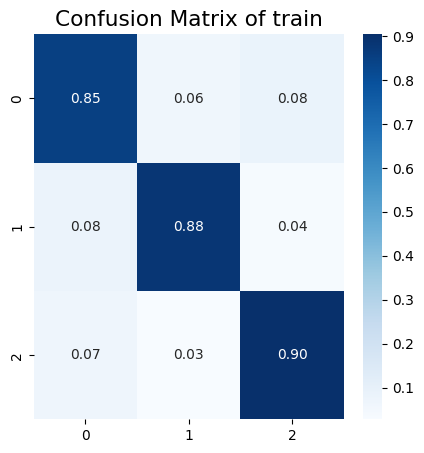

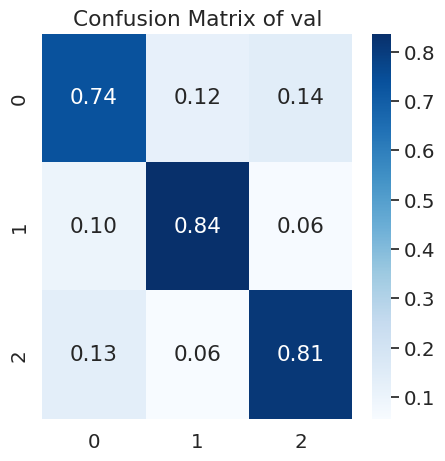

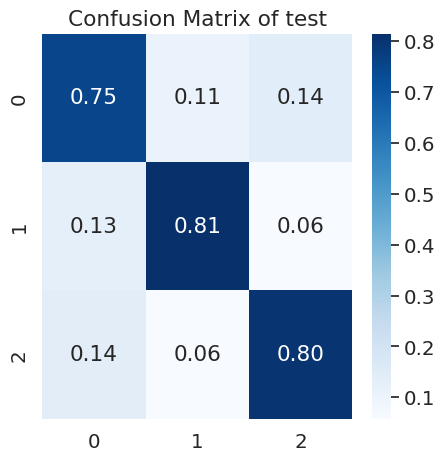

In [35]:
cm_plot(y_train, y_pred_train, 'train')
cm_plot(y_val, y_pred_val, 'val')
cm_plot(y_test, y_pred_test, 'test')

In [36]:
statistic(y_pred_test, y_test, y_pred_train, y_train, 'train', 'test')

,train,test
balanced_accuracy_score,0.879657,0.788779
accuracy_score,0.879657,0.788768
f1 weighted,0.87966,0.789005
f1 micro,0.879657,0.788768
f1 macro,0.87966,0.789019


In [37]:
statistic(y_pred_train, y_train, y_pred_val, y_val, 'dev', 'train')

,dev,train
balanced_accuracy_score,0.794049,0.879657
accuracy_score,0.794072,0.879657
f1 weighted,0.793733,0.87966
f1 micro,0.794072,0.879657
f1 macro,0.793714,0.87966


In [25]:
from google.colab import files
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [26]:
!cp second_robert_sentiment_0.79405.bin xxx